In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
import numpy as np
import pandas as pd
import os, shutil, glob, sys, math, cv2, re

import albumentations as albu

from tqdm import tqdm
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from sklearn.model_selection import train_test_split

In [3]:
DATA_FOLDER = "/home/tsung1271232/pathology/data/tcga/"

In [3]:
# patches_folder = '/nfs/Shared/data/tcga/patches'
# patches_subfolders = sorted(os.listdir(patches_folder))

In [4]:
# cohort_images_dict = {i[:12]: [] for i in patches_subfolders}
# for subfolder in patches_subfolders:
#     cohort_name = subfolder[:12]
#     _tumor = subfolder[13]
#     if _tumor == '1':
#         print(subfolder)
#         continue
#     image_names = glob.glob(os.path.join(patches_folder, subfolder, "*.jpg"))
#     cohort_images_dict[cohort_name].extend(image_names)

# data process

In [5]:
tumor_record_folder = '/nfs/Shared/data/tcga/tumor'
cohort_tumor_npy = sorted(os.listdir(tumor_record_folder))

In [6]:
cohort_images_dict = {i[:12]: [] for i in cohort_tumor_npy}    
for npy in cohort_tumor_npy:
    cohort_name = npy[:12]
    _tumor = npy[13]
    if _tumor == '1':
        print(npy)
        continue
    image_names = np.load(os.path.join(tumor_record_folder, npy))
    cohort_images_dict[cohort_name].extend(image_names)

TCGA-A6-2671-11A-01-TS1.f8122238-e900-407d-b9f8-a1d7ba677bb0.npy
TCGA-A6-2674-11A-01-TS1.9fdaacfa-6ff3-43b9-81d3-3277f6686fb2.npy
TCGA-A6-2675-11A-01-TS1.58e6f457-c41e-4d62-ab99-94d5f8efab83.npy
TCGA-A6-2677-11A-01-TS1.68cd2ccf-8816-400c-80fb-62ec6a03a0e3.npy
TCGA-A6-2678-11A-01-TS1.5a5a17ec-30d4-404a-a0a7-d8a9eeadc127.npy
TCGA-A6-2681-11A-01-TS1.a05117d8-36a5-4b62-a80d-609c9b420ed9.npy
TCGA-A6-2683-11A-01-TS1.9750a80d-ed19-4baa-b0eb-8f3a77b66b00.npy
TCGA-A6-2684-11A-01-TS1.373c2bcf-43e7-4862-ad25-27319410fa23.npy
TCGA-A6-2685-11A-01-TS1.76b18da0-1d51-44a1-8ac7-3024404cbc1a.npy
TCGA-A6-2686-11A-01-TS1.24ec13e0-fc36-47bc-97f6-0bfdadae2387.npy
TCGA-A6-3807-11A-01-BS1.31c26bf0-d481-4fed-8c69-306a30da2d91.npy
TCGA-A6-3807-11A-01-TS1.e73c0645-13ac-43fd-b8be-05036fa31fea.npy
TCGA-A6-3808-11A-01-BS1.2874c8d9-010e-4205-a198-23363209be1f.npy
TCGA-A6-3808-11A-01-TS1.de8d5f36-febb-43d5-8f5c-9bc3842e53ff.npy
TCGA-A6-3809-11A-01-BS1.6c172e19-22b2-445b-afa8-a6aa8ba01421.npy
TCGA-A6-3809-11A-01-TS1.c

In [7]:
# 數量500多，有些沒有images
import pandas as pd
df = pd.read_csv('./data/coad_Mutation_Count.txt', delimiter="\t")
cohort_count_dict = {row[1]: row[3] for index,row in df.iterrows()}

In [8]:
train_cohorts, valid_cohorts = train_test_split(
    list(cohort_images_dict.keys()), test_size=0.33, random_state=0)
print(len(train_cohorts), len(valid_cohorts))

261 129


In [9]:
def get_images_labels(cohorts, cohort_images_dict, cohort_count_dict):
    all_images = []
    all_labels = []
    no_expand_labels = []
    all_sample_weight = []
    
    for cohort in cohorts:
        images = cohort_images_dict[cohort]
        if(len(images) == 0):
            continue
        labels = [cohort_count_dict[cohort]]*len(images)
        sample_weight = [1/len(images)]*len(images)
        all_images.extend(images)
        all_labels.extend(labels)
        all_sample_weight.extend(sample_weight)
        no_expand_labels.append(cohort_count_dict[cohort])
        # softmax, total sum = 1 
    return np.array(all_images), np.array(all_labels), np.array(no_expand_labels), np.array(all_sample_weight)


In [10]:
def cvt2percentile(counts, labels):
    p = [25, 50, 75]
    percentile = np.percentile(counts, p)
    print(percentile)
    percentile_labels = np.zeros_like(labels)
    
    for idx, label in enumerate(labels):
        _foo = (label < percentile)*1
        if np.sum(_foo) == 0:
            percentile_labels[idx] = len(p)
        else:
            for _temp, _i in enumerate(_foo):
                if _i == 1:
                    percentile_labels[idx] = _temp
                    break
    return percentile_labels
def cvt2Classy(labels):
    cut = [100,200]
    classify_labels = np.zeros_like(labels)
    
    for idx, label in enumerate(labels):
        _foo = (label < cut)*1
        if np.sum(_foo) == 0:
            classify_labels[idx] = len(cut)
        else:
            for _temp, _i in enumerate(_foo):
                if _i == 1:
                    classify_labels[idx] = _temp
                    break
    return classify_labels

In [11]:
train_images, train_labels, train_counts, train_sample_weight = get_images_labels(train_cohorts, cohort_images_dict, cohort_count_dict)
valid_images, valid_labels, valid_counts, valid_sample_weight = get_images_labels(valid_cohorts, cohort_images_dict, cohort_count_dict)

print(len(train_images), len(train_labels), len(train_counts), len(valid_images), len(valid_labels), len(valid_counts))

670512 670512 260 310493 310493 128


In [12]:
train_counts = cvt2Classy(train_counts)
valid_counts = cvt2Classy(valid_counts)
train_labels = cvt2Classy(train_labels)
valid_labels = cvt2Classy(valid_labels)

In [13]:
print(np.unique(train_labels), np.unique(valid_labels))

[0 1 2] [0 1 2]


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

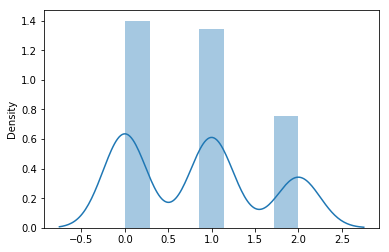

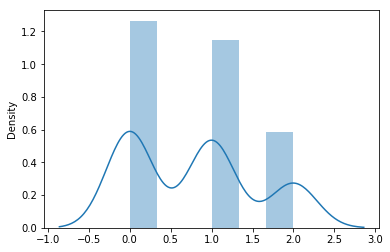

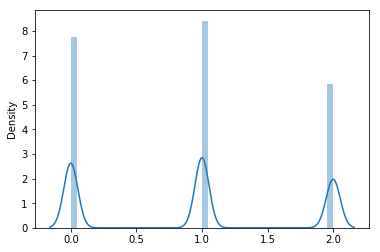

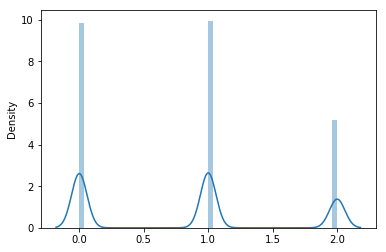

In [14]:
plt.figure()
sns.distplot(train_counts)
plt.figure()
sns.distplot(valid_counts)
plt.figure()
sns.distplot(train_labels)
plt.figure()
sns.distplot(valid_labels)

In [17]:
import random
def sample_from_data(images, labels, seed = 0):
    label0_idx = list(np.where(labels == 0)[0])
    label1_idx = list(np.where(labels == 1)[0])
    label2_idx = list(np.where(labels == 2)[0])
    print(len(label0_idx), len(label1_idx), len(label2_idx))

    random.seed(seed)
    # sampled0_idx = random.choices(label0_idx, weights = train_sample_weight[label0_idx], k = len(label2_idx))
    # sampled1_idx = random.choices(label1_idx, weights = train_sample_weight[label1_idx], k = len(label2_idx))

    sampled0_idx = random.sample(label0_idx, k = len(label2_idx))
    sampled1_idx = random.sample(label1_idx, k = len(label2_idx))
    sample_idx = sampled0_idx + sampled1_idx + label2_idx
    
    this_time_images = images[sample_idx]
    this_time_labels = labels[sample_idx]
    return this_time_images, this_time_labels

In [18]:
this_time_images, this_time_labels = sample_from_data(train_images, train_labels)

236349 256425 177738


# dataset

In [21]:
def get_augmentation(image_size):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height = image_size, width = image_size, always_apply=True),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p = 0.5),
    ]
    return albu.Compose(test_transform)

def get_validaugmentation(image_size):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height = image_size, width = image_size, always_apply=True),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# https://github.com/pytorch/vision/blob/master/torchvision/transforms/functional.py, to_tensor     
def to0_1(x, **kwargs):
    return x/255

def get_preprocessing():
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
        albu.Lambda(image=to0_1, mask=to0_1),
    ]
    return albu.Compose(_transform)

In [22]:
from PIL import Image

class Dataset(BaseDataset):
    
    def __init__(self, image_array, label_array, augmentation=None, preprocessing=None):
        self.image_array = image_array
        self.label_array = label_array
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        fp = self.image_array[i]
        image = Image.open(fp)
        image = np.asarray(image)
       
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        label = self.label_array[i]
#         label = label.astype('float32')
        label = label.astype('int64')
        return image, label
    
    def __len__(self):
        return len(self.image_array)

In [23]:
class labelDataset(BaseDataset):
    
    def __init__(self, label_array):
        self.label_array = label_array
    
    def __getitem__(self, i):
        label = self.label_array[i]
#         label = label.astype('float32')
        label = label.astype('int64')
        return label
    
    def __len__(self):
        return len(self.label_array)

# model setting

In [24]:
import utils

In [25]:
bs = 128
epoch = 60
model_arch = 'resnet18'
use_sampler = True
init_lr = 1e-5
DEVICE = 'cuda'
image_size=256

In [26]:
target = 'cls'

if target == 'cls':
    nclass = len(np.unique(train_labels))
else:
    nclass = 1
print(nclass)

3


In [27]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = init_lr * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [28]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=nclass, bias=True)
)

In [29]:
# train_dataset = Dataset(
#     train_images,
#     train_labels,
#     augmentation=get_augmentation(image_size),
#     preprocessing=get_preprocessing(),
# )

# train_label_dataset = labelDataset(
#     train_labels
# )

valid_dataset = Dataset(
    valid_images,
    valid_labels,
    augmentation=get_validaugmentation(image_size),
    preprocessing=get_preprocessing(),
)

In [30]:
# sampler=utils.imbalance.ImbalancedDatasetSampler(train_label_dataset)

# train_loader = DataLoader(train_dataset, batch_size=bs, sampler = sampler, pin_memory=True, num_workers=32)

# train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=32)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=32)

In [31]:
train_loss = 'ce'
train_metric = 'acc'

loss = utils.metrics.CrossEntropy()
# loss = utils.metrics.MSELoss(max_value=3)
metrics = [
    utils.metrics.Accuracy(),
#     utils.metrics.L1Loss(max_value=3)
]


In [32]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=init_lr),
])

train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
import time
current_time = time.strftime("%Y_%m_%d_%H_%M", time.localtime())

model_name = './weight/' + "{}_MCnt-{}-loss_{}_bs_{}".format(
    current_time, target, train_loss, bs)

cur_metric = 0

train_history = []
valid_history = []
for i in range(0, epoch):
    this_time_images, this_time_labels = sample_from_data(train_images, train_labels, i)
    train_dataset = Dataset(
        this_time_images,
        this_time_labels,
        augmentation=get_augmentation(image_size),
        preprocessing=get_preprocessing(),
    )

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=32)

    
    print('\nEpoch: {}, batch: {}'.format(i, bs))
    
    # lr_scheduler.step()
    adjust_learning_rate(optimizer, i)
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_history.append(train_logs)
    valid_history.append(valid_logs)
    
    if cur_metric < valid_logs[metrics[0].__name__]:
        cur_metric = valid_logs[metrics[0].__name__]
        torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
        print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")

#     if cur_metric > valid_logs[metrics[0].__name__]:
#         cur_metric = valid_logs[metrics[0].__name__]
#         torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
#         print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")


Epoch: 0, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [30:50<00:00,  1.31it/s, cross entropy - 1.199, accuracy - 0.3723]  
Model saved! ./weight/2020_09_30_11_57_MCnt-cls-loss_ce_bs_128_epoch0_acc:0.3723.h5

Epoch: 1, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [30:59<00:00,  1.30it/s, cross entropy - 1.47, accuracy - 0.3469]   

Epoch: 2, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [33:24<00:00,  1.21it/s, cross entropy - 1.415, accuracy - 0.3784]  
Model saved! ./weight/2020_09_30_11_57_MCnt-cls-loss_ce_bs_128_epoch2_acc:0.3784.h5

Epoch: 3, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [31:23<00:00,  1.29it/s, cross entropy - 1.545, accuracy - 0.3779]  

Epoch: 4, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [32:11<00:00,  1.26it/s, cross entropy - 1.774, accuracy - 0.3677]  

Epoch: 5, batch: 128
1e-05
valid: 100%|██████████| 2426/2426 [30:40<00:00,  1.32it/s, cross entropy - 1.661, accuracy - 0.3825]  
Model saved! ./weight/2020_09_30_11_57_MCnt-cl

KeyboardInterrupt: 

In [25]:
torch.save(model.state_dict(), model_name+"_epoch{}_{}_{}".format(i,train_metric, "0.01502")+".h5")

# test

In [33]:
def majority_vote(gt_label_num = 3, pred_labels = None):
    vote = np.zeros(gt_label_num)
    for gt_label in range(gt_label_num):
        pred_num = np.count_nonzero(pred_labels == gt_label)
        vote[gt_label] = pred_num
    return np.argmax(vote), vote

In [24]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=nclass, bias=True)
)
model.load_state_dict(torch.load('./weight/2020_09_29_16_07_MCnt-cls-loss_ce_bs_128_epoch0_acc:0.4124.h5'))
model.to('cuda')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
all_pred_by_mean = []
all_pred_by_vote = []
all_gt = []
#### valid or train?
for test_cohort in valid_cohorts:
    test_images, test_labels, test_counts = get_images_labels([test_cohort], cohort_images_dict, cohort_count_dict)
    
    test_labels = cvt2Classy(test_labels)
    
    print(test_cohort, test_images.shape, test_labels.shape)
    
    test_dataset = Dataset(
        test_images,
        test_labels,
        augmentation = get_augmentation(image_size),
        preprocessing = get_preprocessing()
    )
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=32)
    
    one_person_pred = np.array([])
    one_person_gt = np.array([])
    for data in test_dataloader:
        images, gt= data
        
        images = images.cuda()
        
        with torch.no_grad():
            pred = model(images)
        pred = torch.softmax(pred, dim=1)
        pred = torch.argmax(pred, axis = 1)
        
        pred = pred.detach().cpu().numpy()
        if len(pred.shape) != 1:
            pred = pred.squeeze()
        
        gt = gt.numpy()
        
        one_person_pred = np.concatenate((one_person_pred, pred))
        one_person_gt = np.concatenate((one_person_gt, gt))
    
    if target == 'cls':
        mv, vote = majority_vote(gt_label_num = nclass, pred_labels = one_person_pred)
        all_pred_by_vote.append(mv)
        all_pred_by_mean.append(np.mean(one_person_pred))
        all_gt.append(np.mean(one_person_gt))
        
        ratio = vote/np.sum(vote)
        print("mean: {:.2f}, gt: {}, vote: {}, ratio: {:.2f}, {:.2f}, {:.2f}".format(
            np.mean(one_person_pred), np.mean(one_person_gt), mv, ratio[0], ratio[1], ratio[2]))
    else:
        print(np.mean(one_person_pred), np.mean(one_person_gt))
        all_pred_by_mean.append(np.mean(one_person_pred))
        all_gt.append(np.mean(one_person_gt))

TCGA-AA-3506 (1177,) (1177,)
mean: 0.46, gt: 1.0, vote: 0, ratio: 0.67, 0.21, 0.12
TCGA-AA-3867 (209,) (209,)
mean: 0.15, gt: 0.0, vote: 0, ratio: 0.87, 0.12, 0.01
TCGA-G4-6295 (4681,) (4681,)
mean: 0.80, gt: 1.0, vote: 0, ratio: 0.54, 0.13, 0.34
TCGA-AD-6889 (3647,) (3647,)
mean: 0.98, gt: 2.0, vote: 0, ratio: 0.38, 0.26, 0.36
TCGA-D5-6532 (1185,) (1185,)
mean: 0.64, gt: 0.0, vote: 0, ratio: 0.47, 0.41, 0.12
TCGA-AZ-6606 (10750,) (10750,)
mean: 0.62, gt: 1.0, vote: 0, ratio: 0.60, 0.18, 0.22
TCGA-D5-7000 (1370,) (1370,)
mean: 0.81, gt: 1.0, vote: 1, ratio: 0.36, 0.48, 0.16
TCGA-D5-6531 (2815,) (2815,)
mean: 0.73, gt: 1.0, vote: 0, ratio: 0.46, 0.34, 0.19
TCGA-AA-3811 (1240,) (1240,)
mean: 0.80, gt: 2.0, vote: 0, ratio: 0.57, 0.06, 0.37
TCGA-AY-A69D (2265,) (2265,)
mean: 0.99, gt: 1.0, vote: 1, ratio: 0.28, 0.46, 0.27
TCGA-AA-3982 (387,) (387,)
mean: 0.24, gt: 1.0, vote: 0, ratio: 0.83, 0.11, 0.06
TCGA-A6-6648 (3686,) (3686,)
mean: 0.59, gt: 0.0, vote: 1, ratio: 0.46, 0.49, 0.05
TCGA-A

mean: 0.88, gt: 2.0, vote: 1, ratio: 0.12, 0.88, 0.00
TCGA-A6-A56B (1344,) (1344,)
mean: 0.78, gt: 0.0, vote: 1, ratio: 0.31, 0.60, 0.09
TCGA-CA-5256 (2018,) (2018,)
mean: 0.32, gt: 0.0, vote: 0, ratio: 0.69, 0.31, 0.00
TCGA-G4-6302 (953,) (953,)
mean: 1.61, gt: 2.0, vote: 2, ratio: 0.03, 0.34, 0.64
TCGA-AA-3688 (945,) (945,)
mean: 0.52, gt: 0.0, vote: 0, ratio: 0.54, 0.41, 0.06
TCGA-DM-A1D8 (211,) (211,)
mean: 0.71, gt: 1.0, vote: 1, ratio: 0.29, 0.71, 0.00
TCGA-D5-5541 (234,) (234,)
mean: 0.78, gt: 0.0, vote: 1, ratio: 0.29, 0.63, 0.08
TCGA-AZ-6605 (902,) (902,)
mean: 0.43, gt: 1.0, vote: 0, ratio: 0.71, 0.14, 0.14
TCGA-AA-3989 (1367,) (1367,)
mean: 0.23, gt: 1.0, vote: 0, ratio: 0.82, 0.14, 0.05
TCGA-G4-6297 (3337,) (3337,)
mean: 0.68, gt: 0.0, vote: 1, ratio: 0.41, 0.51, 0.09
TCGA-A6-4105 (4598,) (4598,)
mean: 0.84, gt: 1.0, vote: 1, ratio: 0.18, 0.79, 0.02
TCGA-CK-5913 (0,) (0,)
mean: nan, gt: nan, vote: 0, ratio: nan, nan, nan
TCGA-AA-3846 (350,) (350,)


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


mean: 0.72, gt: 1.0, vote: 1, ratio: 0.29, 0.71, 0.00
TCGA-D5-6931 (2616,) (2616,)
mean: 1.64, gt: 2.0, vote: 2, ratio: 0.13, 0.09, 0.77
TCGA-AA-A01R (3692,) (3692,)
mean: 1.36, gt: 2.0, vote: 2, ratio: 0.29, 0.05, 0.65
TCGA-AA-A01V (6098,) (6098,)
mean: 0.40, gt: 1.0, vote: 0, ratio: 0.65, 0.30, 0.05
TCGA-AD-6901 (218,) (218,)
mean: 0.95, gt: 2.0, vote: 1, ratio: 0.13, 0.78, 0.09
TCGA-AA-3529 (1437,) (1437,)
mean: 0.47, gt: 0.0, vote: 0, ratio: 0.55, 0.43, 0.02
TCGA-CA-5797 (785,) (785,)
mean: 0.36, gt: 0.0, vote: 0, ratio: 0.66, 0.33, 0.02
TCGA-AA-A01I (935,) (935,)
mean: 0.31, gt: 1.0, vote: 0, ratio: 0.70, 0.29, 0.01
TCGA-A6-2678 (1451,) (1451,)
mean: 1.10, gt: 0.0, vote: 1, ratio: 0.24, 0.42, 0.34
TCGA-AA-3812 (758,) (758,)
mean: 0.33, gt: 1.0, vote: 0, ratio: 0.72, 0.24, 0.04
TCGA-D5-6932 (1508,) (1508,)
mean: 0.64, gt: 1.0, vote: 0, ratio: 0.46, 0.44, 0.10
TCGA-D5-6924 (2916,) (2916,)
mean: 0.61, gt: 1.0, vote: 0, ratio: 0.51, 0.36, 0.12
TCGA-DM-A1HA (2261,) (2261,)
mean: 1.74, 

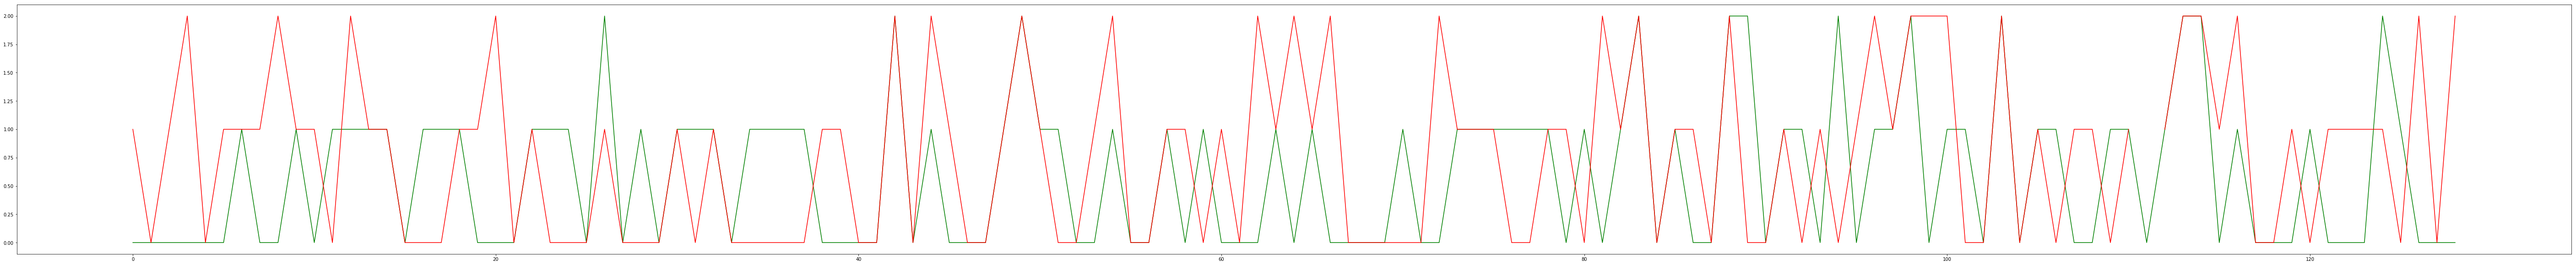

In [40]:
plt.figure(figsize=(100,10))
plt.plot(all_pred_by_vote, color="g")
plt.plot(all_gt, color="r")

In [50]:
tp = np.sum(np.array(all_pred_by_vote) == np.array(all_gt))
print(tp/len(all_gt))

0.4728682170542636


In [32]:
loss = utils.metrics.CrossEntropy()
# loss = utils.metrics.MSELoss(max_value=3)
metrics = [
    utils.metrics.Accuracy(),
#     utils.metrics.L1Loss(max_value=3)
]

valid_dataset = Dataset(
    valid_images,
    valid_labels,
    augmentation=get_validaugmentation(image_size),
    preprocessing=get_preprocessing(),
)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=32)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [33]:
valid_epoch.run(valid_loader)

valid:   0%|          | 0/2426 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered